In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import copy

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

C:\Anaconda3\envs\py27\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Medium

## 4 M1 - Simulate heights from prior

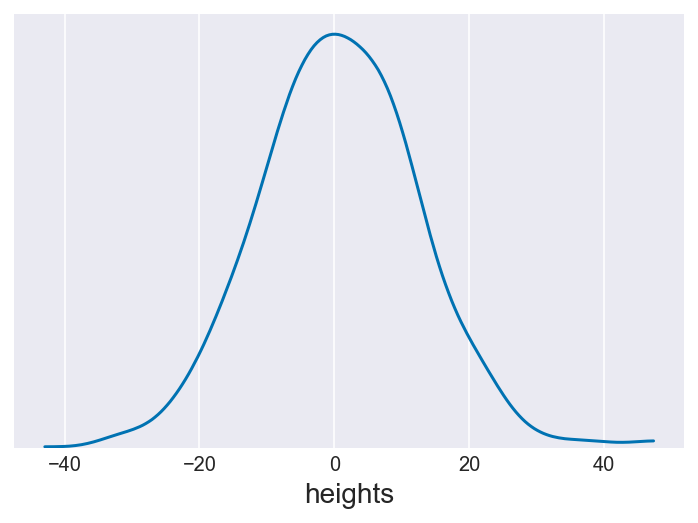

In [2]:
n_samples = 1000
sample_mu = stats.norm.rvs(loc=0, scale=10, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=10, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
pm.kdeplot(prior_h)
plt.xlabel('heights', fontsize=14)
plt.yticks([]);

## 4 M 2 - Translate model into a MAP formula

The python version of this book asks us to look at MCMC instead of MAP. It never introduces map in pymc3, so I'm going to stick with MCMC models instead of MAP .

In [3]:
# with pm.Model() as m4_2:
#     mu = pm.Normal('mu', mu=178, sd=10, testval=d2.height.mean())
#     sigma = pm.Uniform('sigma', lower=0, upper=10, testval=d2.height.std())
#     height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
#     step = pm.DEMetropolis()
#     copy.copy(step)
#     trace_4_2 = pm.sample(1000,step=step,chains=4)

# Hard

## H1

In [66]:
d = pd.read_csv('data/Howell1.csv', sep=';', header=0)
# d2 = d[d.age > 18]
d2['Wcentered']=(d2.weight - d2.weight.mean())

In [67]:
d2.head()

,height,weight,age,male,Wcentered
517,53.9750,4.252425,0.0,0,-14.161768
466,55.8800,4.847764,0.0,0,-13.566429
519,56.5150,5.159609,0.0,0,-13.254584
354,60.4520,5.669900,1.0,1,-12.744293
325,59.6138,5.896696,1.0,0,-12.517497


In [72]:
with pm.Model():
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
#     mu = alpha + beta * d2.Wcentered
    mu = pm.Deterministic('mu', alpha + beta * d2.weight) # try uncomenting this line and comenting the above line
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    trace = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


In [73]:
pm.summary(trace).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,58.316400,1.374144,0.048073,55.721498,61.174167,836.650880,1.004052
beta,2.716313,0.068608,0.002409,2.582866,2.846202,854.051561,1.005067
sigma,8.533432,0.461612,0.013496,7.657942,9.425684,1180.539560,0.999885
mu__0,69.867317,1.120921,0.038344,67.661514,72.124853,843.587795,1.003506
mu__1,71.484445,1.087012,0.037004,69.356367,73.679715,850.282326,1.003401


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000002DDCBA90>,
      dtype=object)

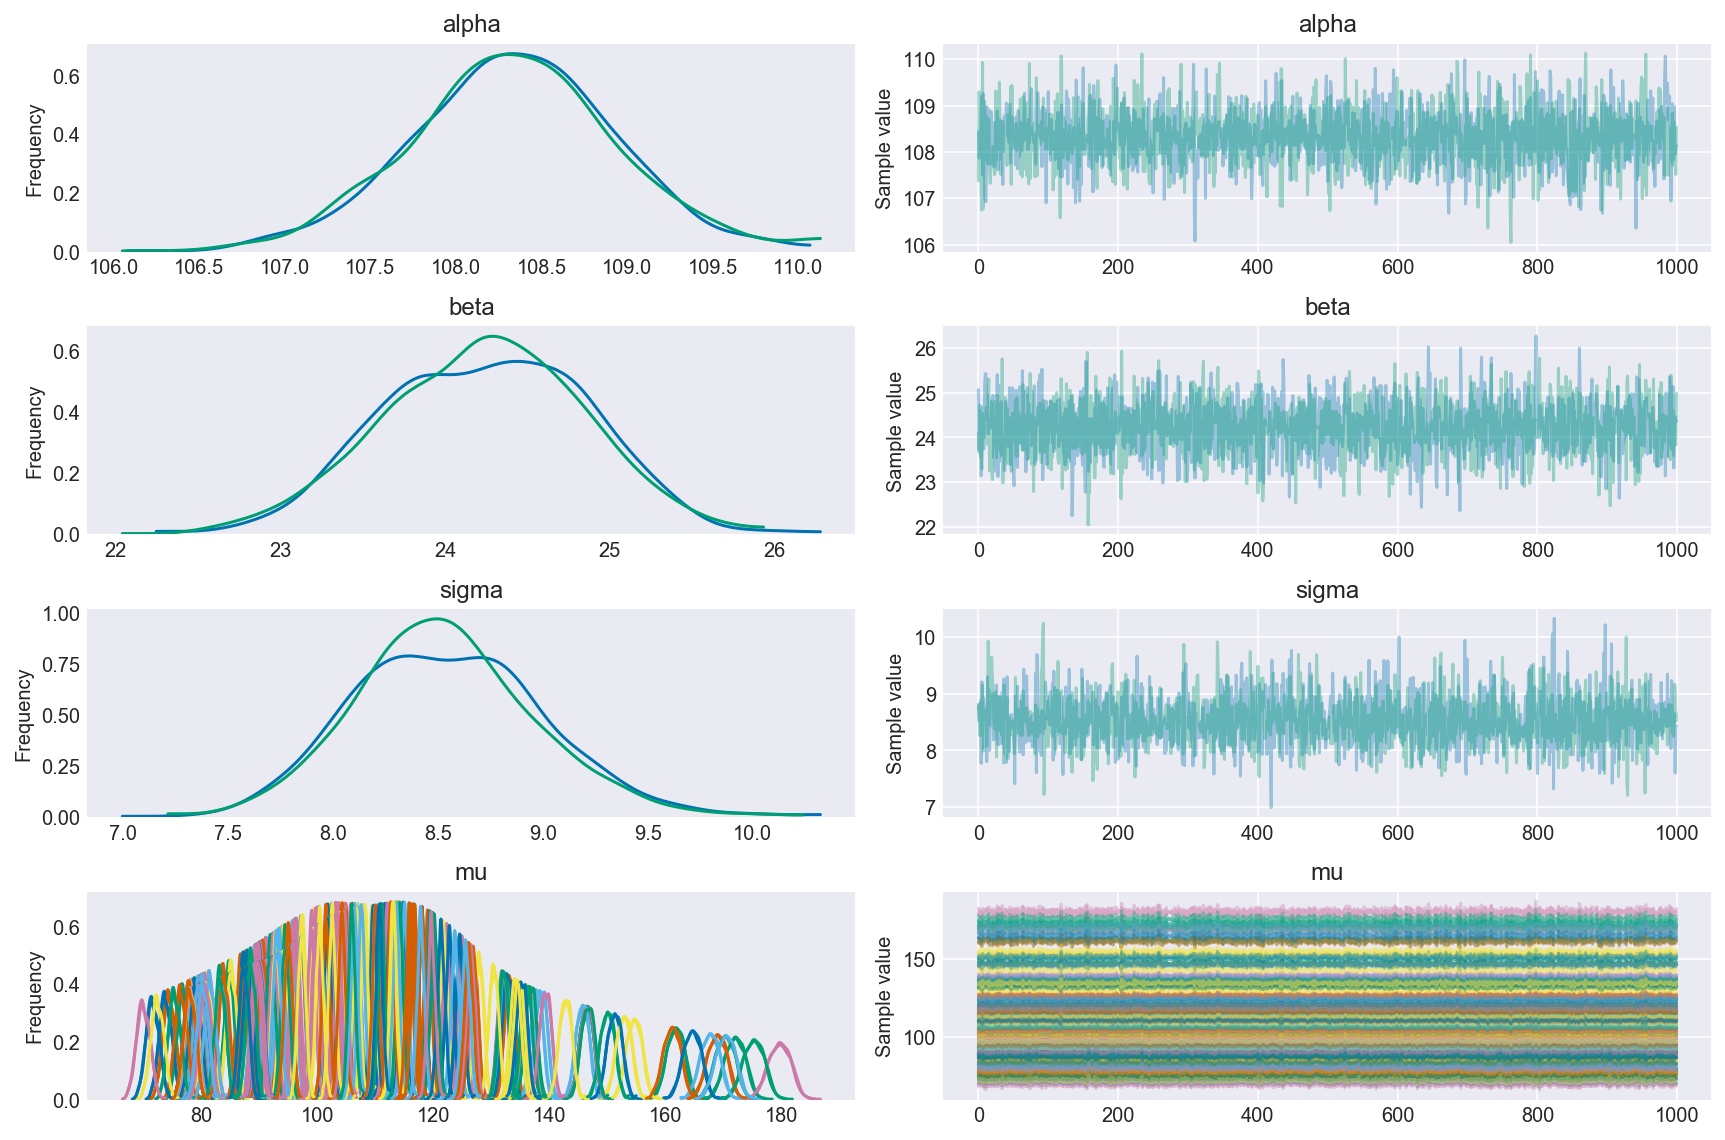

In [74]:
pm.traceplot(trace_m4_2)

In [75]:
weight= np.array([46.95,43.72,64.78,32.59,54.63])
weight =(weight - d2.weight.mean())/d2.weight.std()
# I need to use the model to predict for this weight
pred=[trace_m4_2['alpha'].mean() + trace_m4_2['beta'].mean()*w for w in weight]
print(pred)

[185.6709438007479, 176.9161131267378, 233.99869331084068, 146.74853869895696, 206.48738329808452]


# H2

In [81]:
d = pd.read_csv('data/Howell1.csv', sep=';', header=0)
d2 = d[d.age < 18]
d2 = d2.sort_values('weight')
d2['center']= (d2.weight - d2.weight.mean())

In [82]:
d2.head()

,height,weight,age,male,center
517,53.9750,4.252425,0.0,0,-14.161768
466,55.8800,4.847764,0.0,0,-13.566429
519,56.5150,5.159609,0.0,0,-13.254584
354,60.4520,5.669900,1.0,1,-12.744293
325,59.6138,5.896696,1.0,0,-12.517497


In [129]:
with pm.Model() as m2:
    alpha= pm.Normal('alpha',mu=140,sd=100)
    beta= pm.Normal('beta',mu=0,sd=10)
    sigma = pm.Uniform('sigma',lower=0,upper=50)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight)
    height= pm.Normal('height',mu=mu,sd=sigma,observed = d2.height)
    trace_m2 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]


In [130]:
pm.summary(trace_m2).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,58.251322,1.402468,0.041774,55.371994,60.927354,794.881937,0.999640
beta,2.719307,0.068389,0.002027,2.588128,2.857852,816.989150,0.999515
sigma,8.586772,0.482691,0.014313,7.695620,9.569870,991.365846,0.999502
mu__0,69.814971,1.149611,0.033733,67.510058,72.069317,823.695315,0.999682
mu__1,71.433882,1.115688,0.032631,69.169344,73.597961,830.372091,0.999689


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000003A237DD8>,
      dtype=object)

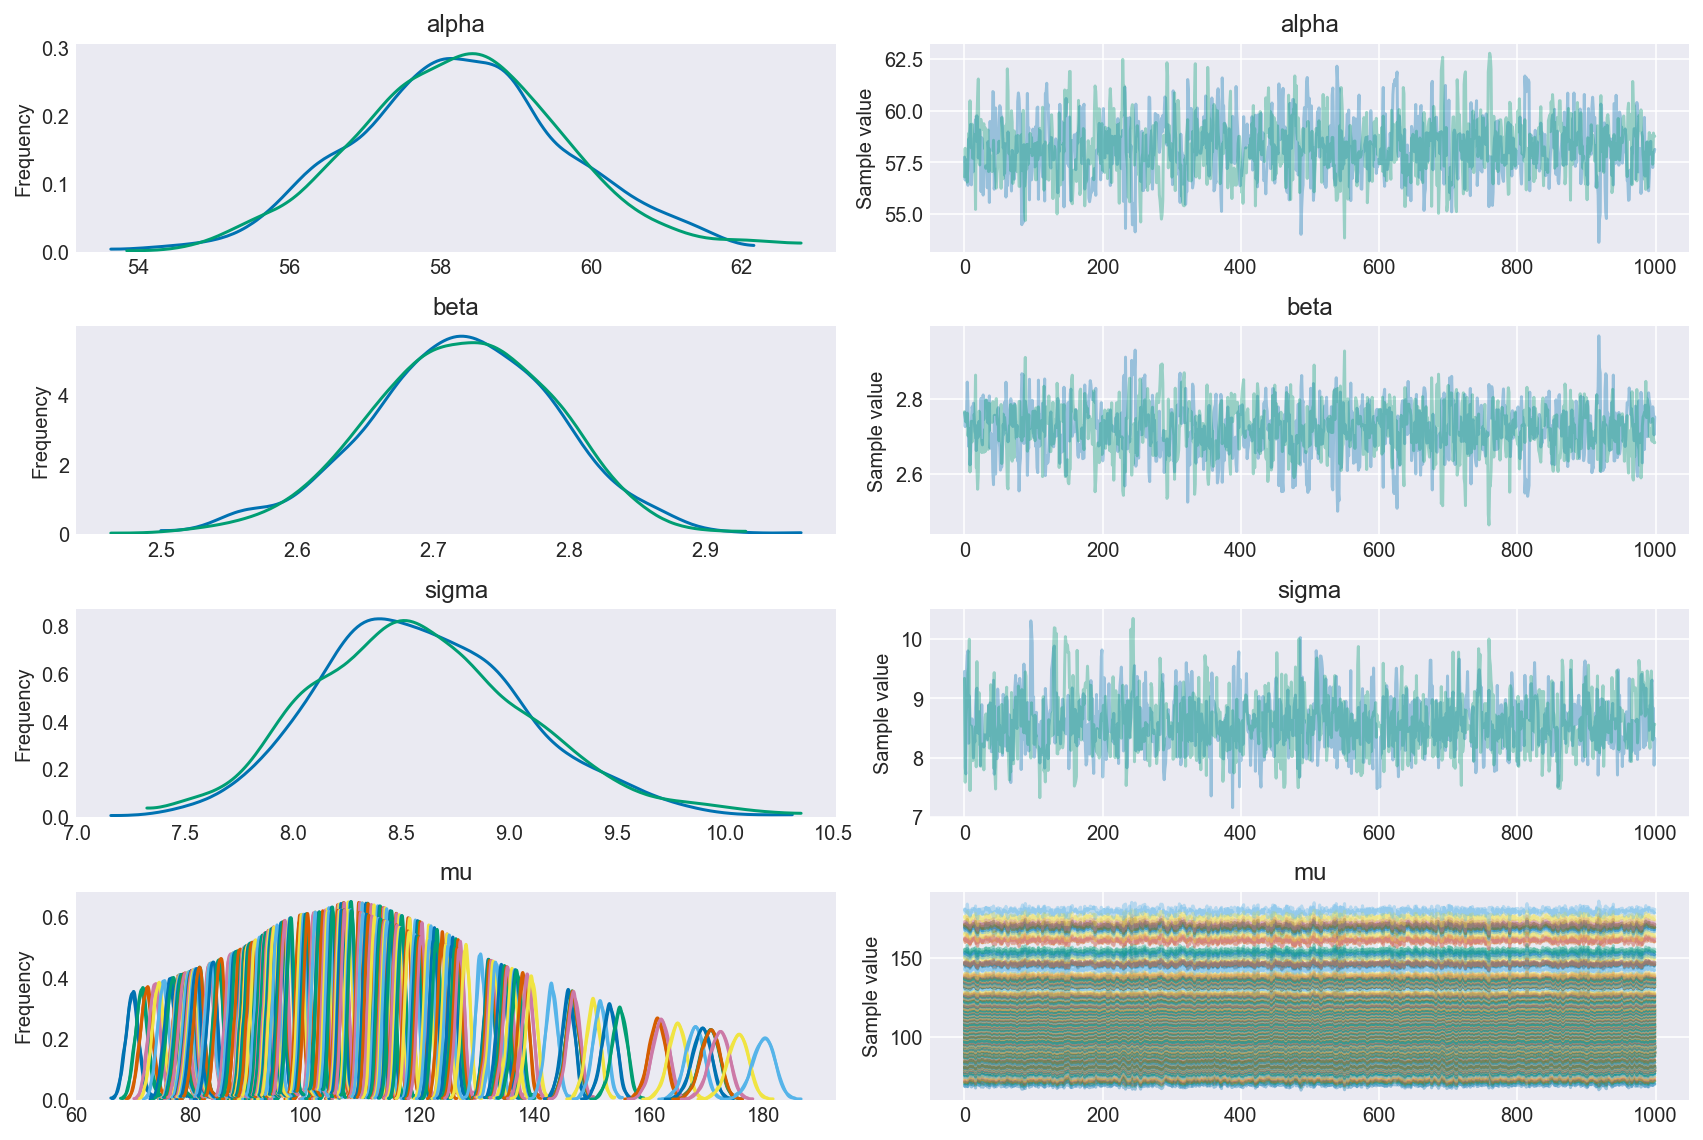

In [131]:
pm.traceplot(trace_m2)

In [ ]:
mu_mean = mu_pred.mean(1)
mu_hpd = pm.hpd(mu_pred.T, alpha=.11)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1574.80it/s]


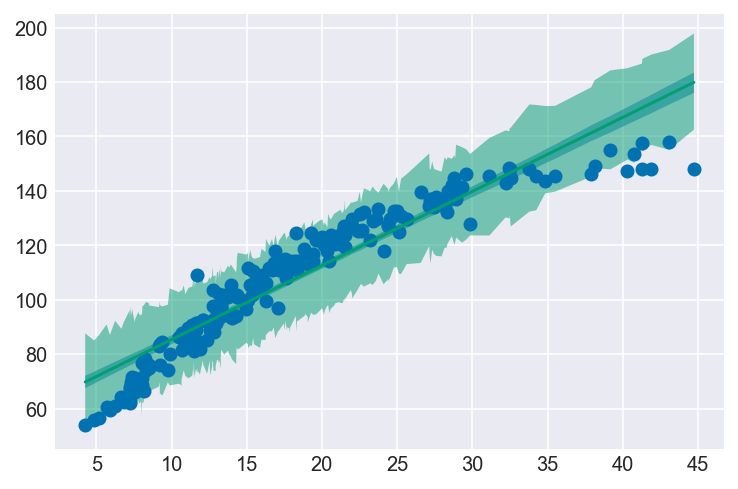

In [134]:
samples = pm.trace_to_dataframe(trace_m2)
obs_hpd = pm.hpd(pm.sample_ppc(trace_m2, 200, m2)['height'])
mu_hpd = pm.hpd(trace_m2['mu'])
plt.plot(d2.weight, d2.height, 'o')
plt.plot(d2.weight, samples.alpha.mean() + samples.beta.mean() * d2.weight)
plt.fill_between(d2.weight, mu_hpd[:,0], mu_hpd[:,1], alpha = 0.5)
plt.fill_between(d2.weight, obs_hpd[:,0], obs_hpd[:,1], alpha = 0.5)

# 4H3

In [157]:
# log modeling
df = pd.read_csv('data/Howell1.csv', sep=';', header=0)
df['center']=(df.weight - df.weight.mean())

In [164]:
with pm.Model() as m3:
    alpha= pm.Normal('alpha',mu=178,sd=100)
    beta= pm.Normal('beta',mu=0,sd=10)
    sigma = pm.Uniform('sigma',lower=0,upper=50)
    mu = pm.Deterministic('mu', alpha + beta * np.log(df.weight))
    height= pm.Normal('height',mu=mu,sd=sigma,observed = df.height)
    trace_m3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_interval__, beta, alpha]
The acceptance probability does not match the target. It is 0.8810165087165588, but should be close to 0.8. Try to increase the number of tuning steps.


In [165]:
pm.summary(trace_m3).head()

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-23.521444,1.282131,0.052479,-25.964462,-21.028788,544.641543,0.999530
beta,46.999293,0.366572,0.015175,46.304350,47.711030,545.694963,0.999511
sigma,5.163464,0.162716,0.004637,4.861677,5.479592,956.388895,1.001563
mu__0,158.251199,0.269437,0.007674,157.690000,158.730595,1283.317271,0.999575
mu__1,145.531410,0.227461,0.004829,145.119307,145.994400,1968.205900,0.999636


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000582B65C0>,
      dtype=object)

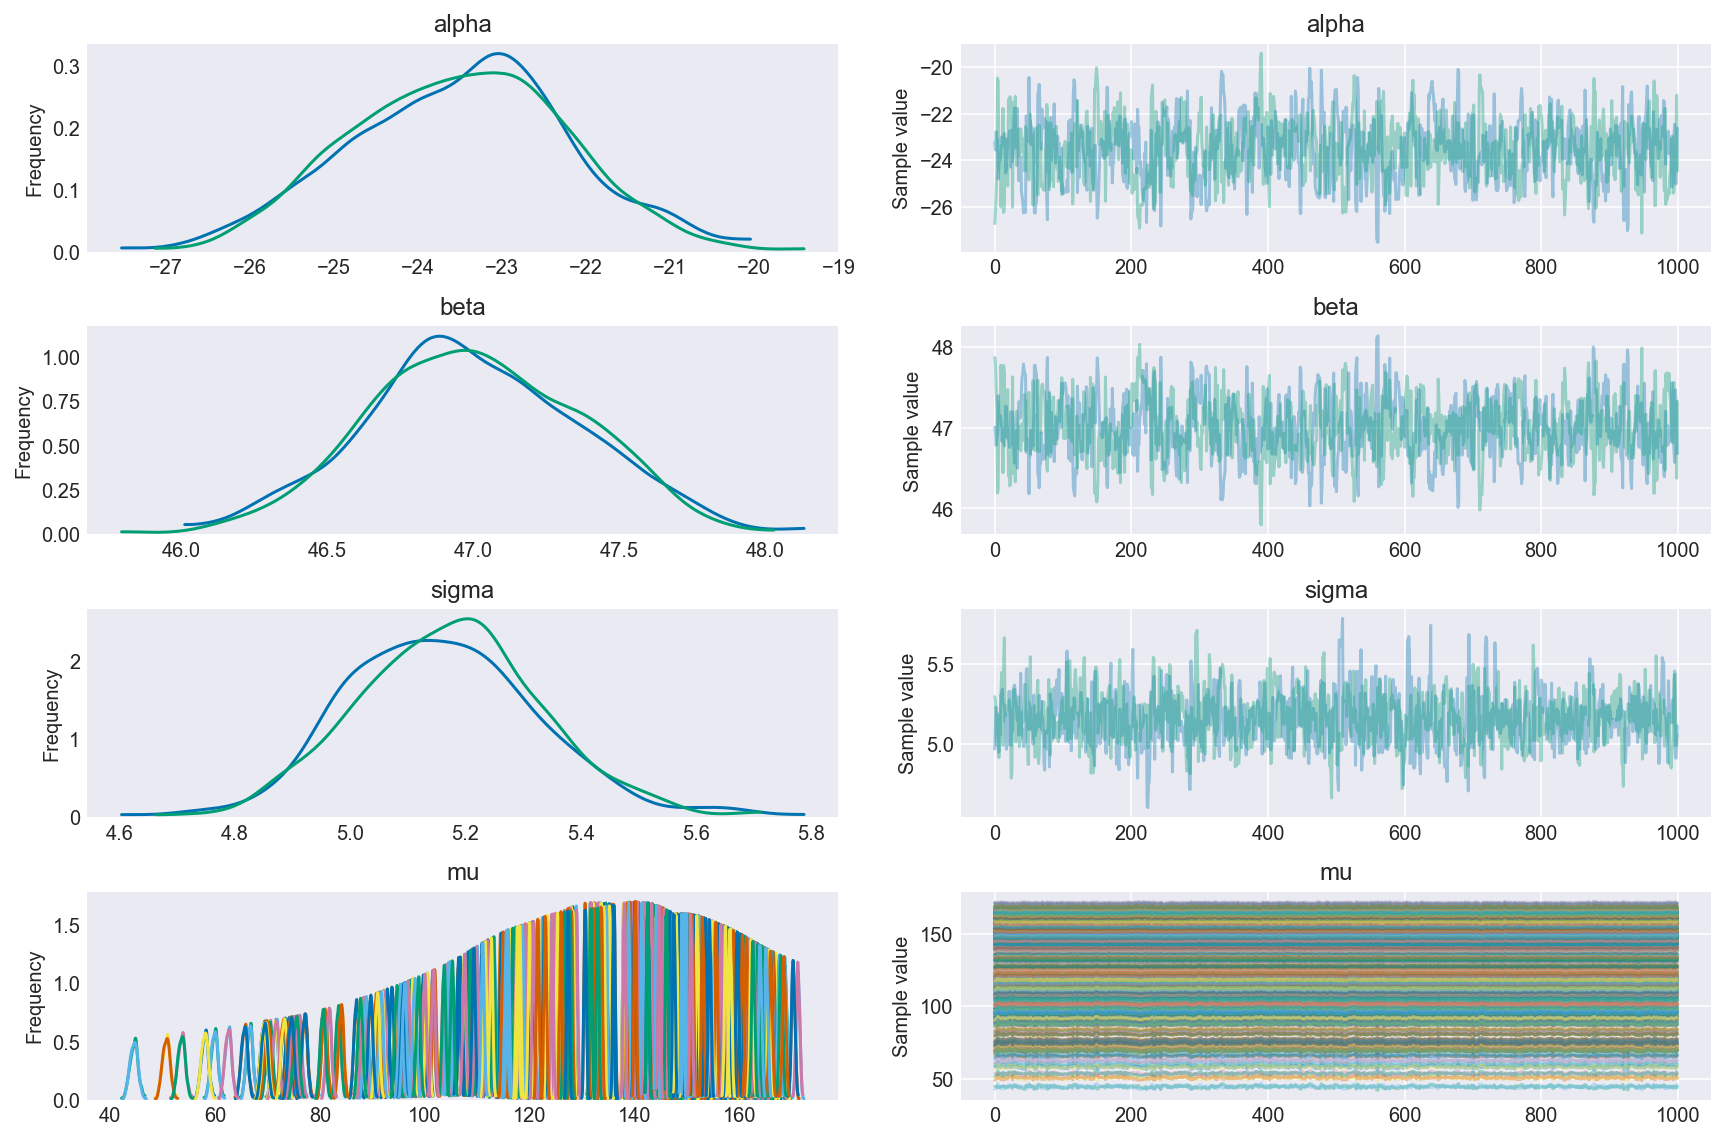

In [166]:
pm.traceplot(trace_m3)

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1111.11it/s]


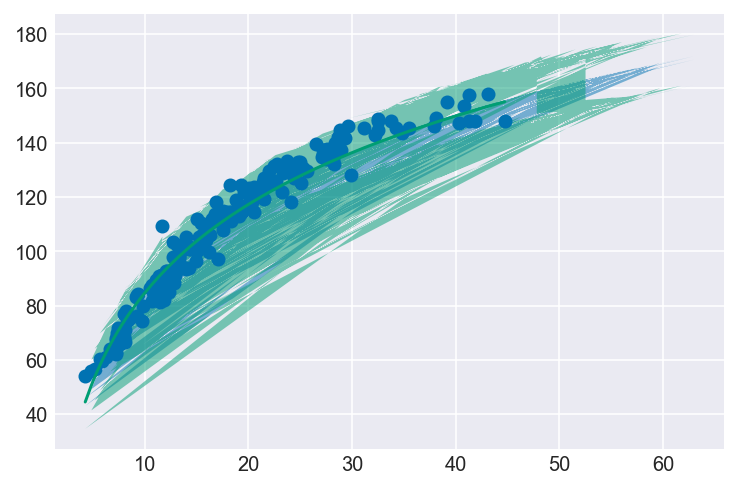

In [167]:
samples = pm.trace_to_dataframe(trace_m3)
obs_hpd = pm.hpd(pm.sample_ppc(trace_m3, 200, m3)['height'])
mu_hpd = pm.hpd(trace_m3['mu'])
plt.plot(d2.weight, d2.height, 'o')
plt.plot(d2.weight, samples.alpha.mean() + samples.beta.mean() * np.log(d2.weight))
plt.fill_between(df.weight, mu_hpd[:,0], mu_hpd[:,1], alpha = 0.5)
plt.fill_between(df.weight, obs_hpd[:,0], obs_hpd[:,1], alpha = 0.5)